# Finding similar documents with FastText and WMD

By using word movers distance we can submit a query and find the most relevant documents.

WMD is a method that allows us to assess the "distance" between two documents in a meaningful way, even when they have no words in common. In this notebook we will use fasttext along with the word movers distance.

This notebook is inspired by the gensim wmd notebook. Please take a look at the notebook and the related paper for more understanding.

  * http://tech.opentable.com/2015/08/11/navigating-themes-in-restaurant-reviews-with-word-movers-distance/
  * https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/WMD_tutorial.ipynb
  
  
Please install gensim, pyemd, nltk to run this notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from time import time
start_nb = time()

In [3]:
# Initialize logging.
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')

sentence_obama = 'Obama speaks to the media in Illinois'
sentence_president = 'The president greets the press in Chicago'
sentence_obama = sentence_obama.lower().split()
sentence_president = sentence_president.lower().split()

These sentences have very similar content, and as such the WMD should be low. Before we compute the WMD, we want to remove stopwords ("the", "to", etc.), as these do not contribute a lot to the information in the sentences.

In [4]:
# Import and download stopwords from NLTK.
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.

# Remove stopwords.
stop_words = stopwords.words('english')
sentence_obama = [w for w in sentence_obama if w not in stop_words]
sentence_president = [w for w in sentence_president if w not in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joydeep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now, as mentioned earlier, we will be using some downloaded pre-trained embeddings. We load these into a Gensim FastText model class. Note that the embeddings we have chosen here require a lot of memory.

In [5]:
start = time()
import os
from gensim.models.fasttext import FastText

from gensim.models import KeyedVectors
if not os.path.exists('wiki.simple.bin'):
    raise ValueError("SKIP: download the wiki simple bin vectors fromm the fasttext website")
    
model = FastText.load_fasttext_format('wiki.simple')

print('Cell took %.2f seconds to run.' % (time() - start))

Cell took 12.93 seconds to run.


So let's compute WMD using the `wmdistance` method.

In [6]:
distance = model.wv.wmdistance(sentence_obama, sentence_president)
print ('distance = %.4f' % distance)

distance = 4.9691


Let's try the same thing with two completely unrelated sentences. Notice that the distance is larger.

In [7]:
sentence_orange = 'Oranges are my favorite fruit'
sentence_orange = sentence_orange.lower().split()
sentence_orange = [w for w in sentence_orange if w not in stop_words]

distance = model.wv.wmdistance(sentence_obama, sentence_orange)
print ('distance = %.4f' % distance)

distance = 6.2539


### Normalizing fasttext vectors

When using the `wmdistance` method, it is beneficial to normalize the fasttext vectors first, so they all have equal length. To do this, simply call `model.init_sims(replace=True)` and Gensim will take care of that for you.

Usually, one measures the distance between two fasttext vectors using the cosine distance (see [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)), which measures the angle between vectors. WMD, on the other hand, uses the Euclidean distance. The Euclidean distance between two vectors might be large because their lengths differ, but the cosine distance is small because the angle between them is small; we can mitigate some of this by normalizing the vectors.

Note that normalizing the vectors can take some time, especially if you have a large vocabulary and/or large vectors.

Usage is illustrated in the example below. It just so happens that the vectors we have downloaded are already normalized, so it won't do any difference in this case.

In [8]:
# Normalizing fasttext vectors.
start = time()

model.init_sims(replace=True)  # Normalizes the vectors in the fasttext class.

distance = model.wv.wmdistance(sentence_obama, sentence_president)  # Compute WMD as normal.

print ('Cell took %.2f seconds to run.' %(time() - start))

Cell took 5.04 seconds to run.


## Part 2: Similarity queries using `WmdSimilarity`

You can use the word movers distance to get the similarities. Please note wwo similar documents will have a *high* similarity score and a small distance; two very different documents will have *low* similarity score, and a large distance.

### Yelp data

Let's try similarity queries using some real world data. For that we'll be using Yelp reviews, available at http://www.yelp.com/dataset_challenge. Specifically, we will be using reviews of a single restaurant. We will use multiple restaurants for training but use only a single restaurant get the queries.

In [9]:
# Pre-processing a document.

from nltk import word_tokenize
download('punkt')  # Download data for tokenizer.

def preprocess(doc):
    doc = doc.lower()  # Lower the text.
    doc = word_tokenize(doc)  # Split into words.
    doc = [w for w in doc if not w in stop_words]  # Remove stopwords.
    doc = [w for w in doc if w.isalpha()]  # Remove numbers and punctuation.
    return doc

[nltk_data] Downloading package punkt to /Users/joydeep/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Download the yelp dataset and keep it in the data folder.

In [10]:
start = time()

import json
import csv
from smart_open import smart_open

# Business IDs of the restaurants.
ids = ['4JNXUYY8wbaaDmk3BPzlWw','RESDUcs7fIiihp38-d6_6g','K7lWdNUhCbcnEvI0NhGewg','cYwJA2A6I12KNkm2rtXd5g','DkYS3arLOhA8si5uUEmHOw', 'f4x1YBxkLrZg652xt2KR5g', '2weQS-RnoOBhb1KsHKyoSQ']


w2v_corpus = []  # Documents to train fasttext on (all 6 restaurants).
wmd_corpus = []  # Documents to run queries against (only one restaurant).
documents = []  # wmd_corpus, with no pre-processing (so we can see the original documents).
with open('data/yelp_review.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for line in reader:
        json_line = line
        
        if json_line['business_id'] not in ids:
            # Not one of the 6 restaurants.
            continue
        
        # Pre-process document.
        text = json_line['text']  # Extract text from JSON object.
        text = preprocess(text)
        
        # Add to corpus for training fasttext.
        w2v_corpus.append(text)
        
        if json_line['business_id'] == ids[0]:
            # Add to corpus for similarity queries.
            wmd_corpus.append(text)
            documents.append(json_line['text'])

print('Cell took %.2f seconds to run.' %(time() - start))

Cell took 134.94 seconds to run.


Below is a plot with a histogram of document lengths and includes the average document length as well. Note that these are the pre-processed documents, meaning stopwords are removed, punctuation is removed, etc. Document lengths have a high impact on the running time of WMD, so when comparing running times with this experiment, the number of documents in query corpus (about 4000) and the length of the documents (about 62 words on average) should be taken into account.

In [11]:
import matplotlib
from matplotlib import pyplot as plt
# matplotlib.use('agg')
%matplotlib inline

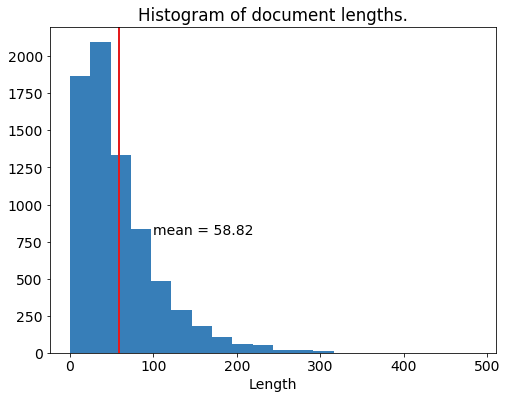

In [12]:
from cycler import cycler
# Document lengths.
lens = [len(doc) for doc in wmd_corpus]

# Plot.
plt.rc('figure', figsize=(8,6))
plt.rc('font', size=14)
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=(cycler('color', ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33'])))
# Histogram.
plt.hist(lens, bins=20)
plt.hold(True)
# Average length.
avg_len = sum(lens) / float(len(lens))
plt.axvline(avg_len, color='#e41a1c')
plt.hold(False)
plt.title('Histogram of document lengths.')
plt.xlabel('Length')
plt.text(100, 800, 'mean = %.2f' % avg_len)
plt.show()

Now we want to initialize the similarity class with a corpus and a fasttext model (which provides the embeddings and the `wmdistance` method itself).

In [13]:
# Train fasttext on all the restaurants.
model = FastText(w2v_corpus, workers=3, size=100)

# Initialize WmdSimilarity.
from gensim.similarities import WmdSimilarity
num_best = 10
instance = WmdSimilarity(wmd_corpus, model, num_best=10)

The `num_best` parameter decides how many results the queries return. Now let's try making a query. The output is a list of indeces and similarities of documents in the corpus, sorted by similarity.

Note that the output format is slightly different when `num_best` is `None` (i.e. not assigned). In this case, you get an array of similarities, corresponding to each of the documents in the corpus.

The query below is taken directly from one of the reviews in the corpus. Let's see if there are other reviews that are similar to this one.

In [14]:
start = time()

sent = 'Very good, you should seat outdoor.'
query = preprocess(sent)

sims = instance[query]  # A query is simply a "look-up" in the similarity class.

print ('Cell took %.2f seconds to run.' %(time() - start))

Cell took 51.63 seconds to run.


The query and the most similar documents, together with the similarities, are printed below. We see that the retrieved documents are discussing the same thing as the query, although using different words. The query talks about getting a seat "outdoor", while the results talk about sitting "outside", and one of them says the restaurant has a "nice view".

In [15]:
# Print the query and the retrieved documents, together with their similarities.
print ('Query:')
print (sent)
for i in range(num_best):
    print()
    print ('sim = %.4f' % sims[i][1])
    print (documents[sims[i][0]])

Query:
Very good, you should seat outdoor.

sim = 0.5853
It's a great place if you can sit outside in good weather.

sim = 0.5635
The steak was good. Prices reasonable for the strip and it was a great view with the outdoor seating.

sim = 0.5470
Best seat in the house with view of water fountain, good wine, good food n good service.

sim = 0.5451
Sat outside under heat lamps.  Good service and good food.  Wonderful place

sim = 0.5438
Lovely restaurant. Food was very good. Drinks very good. View of Bellagio fountains...amazing.

sim = 0.5421
Very good salmon
Nice ambience
Nice view 
Good service

sim = 0.5355
Bad service at the bar and restaurant, but good food and outdoor seating and reasonable pricing.

sim = 0.5353
Good value restaurant on strip! 
Great view take outside seat good food!
However, be sure you make reservation!

sim = 0.5315
sit on the patio and people watch.. great time.

sim = 0.5312
Great restaurant with a decent price. The steaks are good and the atmosphere is grea

Let's try a different query, also taken directly from one of the reviews in the corpus.

In [16]:
start = time()

sent = 'I felt that the prices were extremely reasonable for the Strip'
query = preprocess(sent)

sims = instance[query]  # A query is simply a "look-up" in the similarity class.

print ('Query:')
print (sent)
for i in range(num_best):
    print()
    print ('sim = %.4f' % sims[i][1])
    print (documents[sims[i][0]])

print ('\nCell took %.2f seconds to run.' %(time() - start))

Query:
I felt that the prices were extremely reasonable for the Strip

sim = 0.5513
The steak was good. Prices reasonable for the strip and it was a great view with the outdoor seating.

sim = 0.5413
Incredible restaurant on the strip! Very reasonable prices, outstanding service, an breathtaking views. Bar none, my favorite meal on the Strip.

sim = 0.5392
Great breakfast (wonderful house-made English muffins!), and fair prices for the Strip.

sim = 0.5374
don't let the tourist location throw you. terrific French food on the strip without the strip prices.

sim = 0.5327
Good food, great atmosphere, reasonable prices.  Right in the middle of the Strip.  Nothing not to like here.

sim = 0.5297
Very delicious breakfast. The food quality is great, location is prime and comparably reasonable prices!

sim = 0.5261
Everytime I arrive in Vegas I eat here.  The food is great. The prices are decent.  The atmosphere on the strip is unbelievable.

sim = 0.5242
Really good food at decent prices (fo

This time around, the results are more straight forward; the retrieved documents basically contain the same words as the query.

`WmdSimilarity` normalizes the word embeddings by default (using `init_sims()`, as explained before), but you can overwrite this behaviour by calling `WmdSimilarity` with `normalize_w2v_and_replace=False`.

In [17]:
print ('Notebook took %.2f seconds to run.' %(time() - start_nb))

Notebook took 396.12 seconds to run.


## References

1. Ofir Pele and Michael Werman, *A linear time histogram metric for improved SIFT matching*, 2008.
* Ofir Pele and Michael Werman, *Fast and robust earth mover's distances*, 2009.
* Matt Kusner et al. *From Embeddings To Document Distances*, 2015.
* Thomas Mikolov et al. *Efficient Estimation of Word Representations in Vector Space*, 2013.